# I'm Something of a Painter Myself - CycleGAN Implementation

## 1. Introduction
This notebook implements a CycleGAN to translate photos into Monet-style paintings.
Competition: [I'm Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started/overview)

**Strategy**:
1.  **Data**: Load from Google Drive (Zip file) for faster IO.
2.  **Model**: CycleGAN (ResNet Generator + PatchGAN Discriminator).
3.  **Framework**: PyTorch.

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Set random seed for reproducibility
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 2. Data Pipeline

### Data Loading Strategy
We will download the dataset directly from a shared Google Drive link.
1.  Use `gdown` to download the zip file from the shared link.
2.  Unzip it to the local environment.
This method works in both Colab and local VS Code environments without requiring authentication.

In [2]:
import os
import shutil
import gdown

# 1. Define paths and Google Drive File ID
# Shared Link: https://drive.google.com/file/d/1Wf8cZM1QboZamZDoL9hcuA8yIFUQtgEb/view?usp=sharing
file_id = '1Wf8cZM1QboZamZDoL9hcuA8yIFUQtgEb'
url = f'https://drive.google.com/uc?id={file_id}'

# Use current directory or /content/ if it exists (Colab default)
base_dir = '/content' if os.path.exists('/content') else '.'
local_zip_path = os.path.join(base_dir, 'gan-getting-started.zip')
dataset_dir = os.path.join(base_dir, 'dataset')

# 2. Download and Unzip
if not os.path.exists(dataset_dir):
    print(f"Downloading zip file to {local_zip_path}...")
    # gdown might need to be installed: pip install gdown
    gdown.download(url, local_zip_path, quiet=False)

    print("Unzipping...")
    shutil.unpack_archive(local_zip_path, dataset_dir)
    print("Done!")
else:
    print("Dataset already exists.")

# 3. Verify
if os.path.exists(dataset_dir):
    photo_dir = os.path.join(dataset_dir, 'photo_jpg')
    monet_dir = os.path.join(dataset_dir, 'monet_jpg')
    if os.path.exists(photo_dir) and os.path.exists(monet_dir):
        print(f"Photos: {len(os.listdir(photo_dir))}")
        print(f"Monet: {len(os.listdir(monet_dir))}")
    else:
        print("Directories not found. Check unzip structure.")

Downloading...
From (original): https://drive.google.com/uc?id=1Wf8cZM1QboZamZDoL9hcuA8yIFUQtgEb
From (redirected): https://drive.google.com/uc?id=1Wf8cZM1QboZamZDoL9hcuA8yIFUQtgEb&confirm=t&uuid=25482d73-802a-4f19-833d-9d3faabda5a0
To: /content/gan-getting-started.zip
100%|██████████| 385M/385M [00:03<00:00, 107MB/s]


Unzipping...
Done!
Photos: 7038
Monet: 300


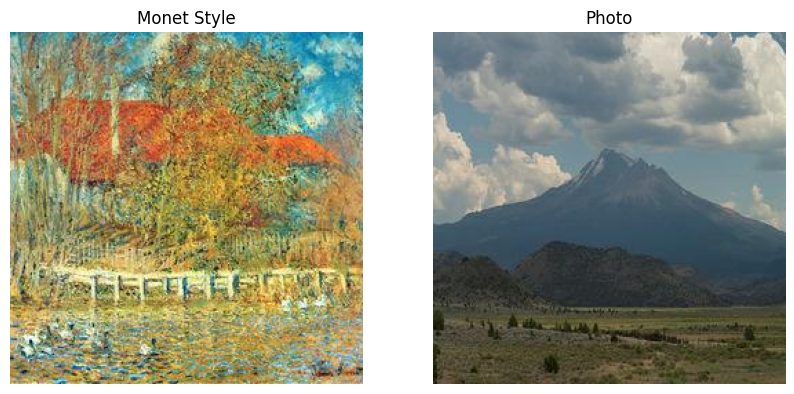

In [3]:
class ImageDataset(Dataset):
    def __init__(self, root_monet, root_photo, transform=None):
        self.root_monet = root_monet
        self.root_photo = root_photo
        self.transform = transform

        self.monet_images = os.listdir(root_monet)
        self.photo_images = os.listdir(root_photo)
        self.length_dataset = max(len(self.monet_images), len(self.photo_images))
        self.monet_len = len(self.monet_images)
        self.photo_len = len(self.photo_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        monet_img = self.monet_images[index % self.monet_len]
        photo_img = self.photo_images[index % self.photo_len]

        monet_path = os.path.join(self.root_monet, monet_img)
        photo_path = os.path.join(self.root_photo, photo_img)

        monet_img = np.array(Image.open(monet_path).convert("RGB"))
        photo_img = np.array(Image.open(photo_path).convert("RGB"))

        if self.transform:
            # Note: If using albumentations, the call is different.
            # Here we assume standard torchvision transforms for simplicity in this starter
            # For better results, consider using albumentations for augmentation
            monet_img = Image.fromarray(monet_img)
            photo_img = Image.fromarray(photo_img)
            monet_img = self.transform(monet_img)
            photo_img = self.transform(photo_img)

        return monet_img, photo_img

# Transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create DataLoader
dataset = ImageDataset(
    root_monet=os.path.join(dataset_dir, 'monet_jpg'),
    root_photo=os.path.join(dataset_dir, 'photo_jpg'),
    transform=transform
)
loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)

# Visualization
def show_sample(loader):
    monet, photo = next(iter(loader))
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # Denormalize
    monet = monet * 0.5 + 0.5
    photo = photo * 0.5 + 0.5

    ax[0].imshow(monet[0].permute(1, 2, 0))
    ax[0].set_title("Monet Style")
    ax[0].axis("off")

    ax[1].imshow(photo[0].permute(1, 2, 0))
    ax[1].set_title("Photo")
    ax[1].axis("off")
    plt.show()

show_sample(loader)

## 3. Model Architecture (CycleGAN)

We need:
1.  **Generator**: ResNet-based (9 blocks for 256x256 images).
2.  **Discriminator**: PatchGAN (70x70 PatchGAN).
3.  **Weights Initialization**: Normal distribution with mean 0.0, std 0.02.
4.  **Replay Buffer**: To store generated images for discriminator training stability.

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels=3, num_residuals=9):
        super(Generator, self).__init__()
        # Initial Convolution
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(img_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        ]
        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual Blocks
        for _ in range(num_residuals):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output Layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, img_channels, 7),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super(Discriminator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, features[0], 4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, feature, 4, stride=1 if feature == features[-1] else 2, padding=1, padding_mode="reflect"),
                    nn.InstanceNorm2d(feature),
                    nn.LeakyReLU(0.2, inplace=True),
                )
            )
            in_channels = feature

        layers.append(nn.Conv2d(in_channels, 1, 4, stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(self.initial(x))

def init_weights(net, init_type='normal', init_gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            nn.init.normal_(m.weight.data, 1.0, init_gain)
            nn.init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

## 4. Training Loop
This section defines the training loop.
*   **Losses**: Adversarial (MSE), Cycle (L1), Identity (L1).
*   **Optimizers**: Adam.
*   **Loop**: Iterate through epochs, update G and D.

In [6]:
# Hyperparameters
LEARNING_RATE = 2e-4
BATCH_SIZE = 32 # Increased from 1 (effective) to 32 for A100. 128 might be too large for VRAM.
NUM_EPOCHS = 2
LAMBDA_CYCLE = 10
LAMBDA_IDENTITY = 0.5

# Re-create DataLoader to apply BATCH_SIZE and parallel loading
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

# Initialize Models
gen_Z = Generator(img_channels=3, num_residuals=9).to(device) # Photo -> Monet
gen_P = Generator(img_channels=3, num_residuals=9).to(device) # Monet -> Photo
disc_Z = Discriminator(in_channels=3).to(device) # Classify Monet
disc_P = Discriminator(in_channels=3).to(device) # Classify Photo

# Initialize Weights
init_weights(gen_Z)
init_weights(gen_P)
init_weights(disc_Z)
init_weights(disc_P)

# Optimizers
opt_gen = optim.Adam(
    list(gen_Z.parameters()) + list(gen_P.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)
opt_disc = optim.Adam(
    list(disc_Z.parameters()) + list(disc_P.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

# Schedulers
# Linear decay after 15 epochs
def lambda_rule(epoch):
    lr_l = 1.0 - max(0, epoch + 1 - 15) / float(15 + 1)
    return lr_l
scheduler_gen = optim.lr_scheduler.LambdaLR(opt_gen, lr_lambda=lambda_rule)
scheduler_disc = optim.lr_scheduler.LambdaLR(opt_disc, lr_lambda=lambda_rule)

# Losses
L1 = nn.L1Loss()
mse = nn.MSELoss()

# Buffers
fake_monet_buffer = ReplayBuffer()
fake_photo_buffer = ReplayBuffer()

def train_fn(disc_Z, disc_P, gen_Z, gen_P, loader, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler):
    loop = tqdm(loader, leave=True)

    for idx, (monet, photo) in enumerate(loop):
        monet = monet.to(device)
        photo = photo.to(device)

        # Train Generators H and Z
        with torch.amp.autocast('cuda'):
            # Identity loss
            fake_monet = gen_Z(monet)
            loss_identity_monet = L1(fake_monet, monet) * LAMBDA_IDENTITY

            fake_photo = gen_P(photo)
            loss_identity_photo = L1(fake_photo, photo) * LAMBDA_IDENTITY

            # GAN loss
            fake_monet = gen_Z(photo)
            D_Z_fake = disc_Z(fake_monet)
            loss_GAN_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            fake_photo = gen_P(monet)
            D_P_fake = disc_P(fake_photo)
            loss_GAN_P = mse(D_P_fake, torch.ones_like(D_P_fake))

            # Cycle loss
            cycle_monet = gen_Z(fake_photo)
            loss_cycle_monet = L1(cycle_monet, monet) * LAMBDA_CYCLE

            cycle_photo = gen_P(fake_monet)
            loss_cycle_photo = L1(cycle_photo, photo) * LAMBDA_CYCLE

            # Total loss
            loss_G = (
                loss_GAN_Z
                + loss_GAN_P
                + loss_cycle_monet
                + loss_cycle_photo
                + loss_identity_monet
                + loss_identity_photo
            )

        opt_gen.zero_grad()
        g_scaler.scale(loss_G).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        # Train Discriminators H and Z
        with torch.amp.autocast('cuda'):
            # Discriminator P
            D_P_real = disc_P(photo)
            loss_D_P_real = mse(D_P_real, torch.ones_like(D_P_real))

            fake_photo_ = fake_photo_buffer.push_and_pop(fake_photo)
            D_P_fake = disc_P(fake_photo_.detach())
            loss_D_P_fake = mse(D_P_fake, torch.zeros_like(D_P_fake))
            loss_D_P = (loss_D_P_real + loss_D_P_fake) / 2

            # Discriminator Z
            D_Z_real = disc_Z(monet)
            loss_D_Z_real = mse(D_Z_real, torch.ones_like(D_Z_real))

            fake_monet_ = fake_monet_buffer.push_and_pop(fake_monet)
            D_Z_fake = disc_Z(fake_monet_.detach())
            loss_D_Z_fake = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            loss_D_Z = (loss_D_Z_real + loss_D_Z_fake) / 2

            # Total loss
            loss_D = (loss_D_P + loss_D_Z) / 2

        opt_disc.zero_grad()
        d_scaler.scale(loss_D).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        if idx % 200 == 0:
            loop.set_postfix(loss_G=loss_G.item(), loss_D=loss_D.item())

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

# Training
g_scaler = torch.amp.GradScaler('cuda')
d_scaler = torch.amp.GradScaler('cuda')

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_fn(disc_Z, disc_P, gen_Z, gen_P, loader, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler)

    # Step schedulers
    scheduler_gen.step()
    scheduler_disc.step()

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        save_checkpoint(gen_Z, opt_gen, filename=f"gen_Z_{epoch+1}.pth.tar")
        save_checkpoint(gen_P, opt_gen, filename=f"gen_P_{epoch+1}.pth.tar")

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
Epoch 1/2


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch 2/2


  0%|          | 0/220 [00:00<?, ?it/s]

## 5. Inference & Submission
Generate Monet-style images from all photos and save them to a zip file.

In [7]:
import shutil

def generate_images(gen_Z, photo_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    gen_Z.eval()
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    print(f"Generating images from {photo_dir}...")
    photo_files = os.listdir(photo_dir)

    with torch.no_grad():
        for i, file in enumerate(tqdm(photo_files)):
            img_path = os.path.join(photo_dir, file)
            img = Image.open(img_path).convert("RGB")
            img = transform(img).unsqueeze(0).to(device)

            fake_monet = gen_Z(img)

            # Denormalize
            fake_monet = fake_monet * 0.5 + 0.5
            fake_monet = fake_monet.squeeze(0).cpu().detach()

            # Save
            save_path = os.path.join(output_dir, file)
            # Convert to PIL and save
            transforms.ToPILImage()(fake_monet).save(save_path)

    print("Generation complete.")

# Generate
output_dir = 'images'
photo_dir = os.path.join(dataset_dir, 'photo_jpg')
generate_images(gen_Z, photo_dir, output_dir)

# Zip
shutil.make_archive('images', 'zip', output_dir)
print("Images zipped successfully. Ready for submission!")

Generating images from /content/dataset/photo_jpg...


  0%|          | 0/7038 [00:00<?, ?it/s]

Generation complete.
Images zipped successfully. Ready for submission!
